In [16]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface)
import vis.fields
import matplotlib.cm as cm
import time

In [17]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [18]:
rod_length = 0.5
width = rod_length / 50 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('sphere_1', thickness, width, weaving_dir)
# This is just to get a random surface

0.05 0.0034999999999999996


In [19]:
io.MODEL_NAME = 'regular_4_100'
io.MODEL_PATH = '{}.obj'.format(io.MODEL_NAME)
io.SUBDIVISION_RESOLUTION = 100

In [20]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

### Initialization

In [21]:
import pickle 
import gzip
# pickle.dump(curved_linkage, gzip.open('{}_{}.pkl.gz'.format(io.MODEL_NAME, time.time()), 'w'))

In [22]:
# curved_linkage = pickle.load(gzip.open('regular_4_7_1607520544.236602.pkl.gz', 'r'))
# curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# curved_linkage_view.show()

In [23]:
# np.save('{}_design_parameters.npy'.format(io.MODEL_NAME), curved_linkage.getDesignParameters())

In [25]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = False, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions()
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

RuntimeError: Couldn't open input file

In [40]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [41]:
curved_linkage_view.update(scalarField=colors)

In [14]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [15]:
# curved_linkage.setDesignParameters(np.load('{}_design_parameters.npy'.format(io.MODEL_NAME)))

In [16]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()

In [19]:
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0, niter = 40)

In [20]:
curved_linkage.attraction_weight = 0

In [21]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [22]:
def eqm_callback(prob, i):
    curved_linkage_view.update(scalarField=colors)

In [23]:
driver=curved_linkage.centralJoint()
jdo = curved_linkage.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
with so(): elastic_rods.compute_equilibrium(curved_linkage, fixedVars=fixedVars, callback = eqm_callback, options = OPTS)

In [24]:
# curved_save_tgt_joint_pos = curved_linkage.jointPositions()

In [25]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [26]:
optimizer.scaleJointWeights(1, 1, [])

In [27]:
optimizer.set_holdClosestPointsFixed(True)

In [28]:
optimizer.beta = 1e4

In [29]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, no_surface = True, maxIter = 100)

rl_regularization_weight 1.0
smoothing_weight 10.0


In [30]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
# os.chdir(save_path)

## Contact Optimization

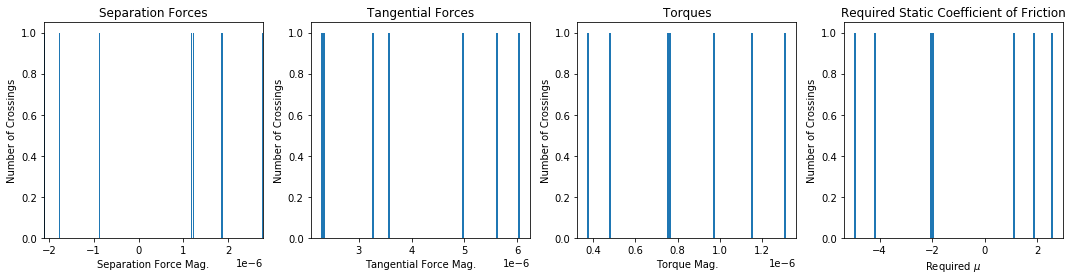

In [31]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [33]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

In [34]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [0 1 3 6]
0	0.000317551	0.186354	0.186354	1	1
1	0.000103248	0.236927	0.236927	1	1
2	5.22282e-05	0.0158857	0.0158857	1	1
3	4.30743e-05	0.00631714	0.00631714	1	1
4	3.57745e-05	0.0039845	0.0039845	1	1
5	2.97108e-05	0.00274089	0.00274089	1	1
6	2.49057e-05	0.00203027	0.00203027	1	1
7	2.13922e-05	0.00161313	0.00161313	1	1
8	1.9037e-05	0.00112383	0.00112383	1	1
9	1.75532e-05	0.00068495	0.00068495	1	1
10	1.66463e-05	0.000403834	0.000403834	1	1
11	1.60986e-05	0.000240411	0.000240411	1	1
12	1.57717e-05	0.000148147	0.000148147	1	1
13	1.55789e-05	9.41336e-05	9.41336e-05	1	1
14	1.5465e-05	6.07963e-05	6.07963e-05	1	1
15	1.53969e-05	3.9524e-05	3.9524e-05	1	1
16	1.53556e-05	2.59403e-05	2.59403e-05	1	1
17	1.53305e-05	1.71911e-05	1.71911e-05	1	1
18	1.53152e-05	1.17934e-05	1.17934e-05	1	1
19	1.53065e-05	8.57852e-06	8.57852e-06	0.5	0
20	1.52975e-05	0.000295464	0.000295464	1	1
21	1.52931e-05	1.66263e-06	1.66263e-06	1	1
22	1.52922e-05	1.76913e-06	1.76913e-06	1	1
23	1.52914e-05	2.85585e-0

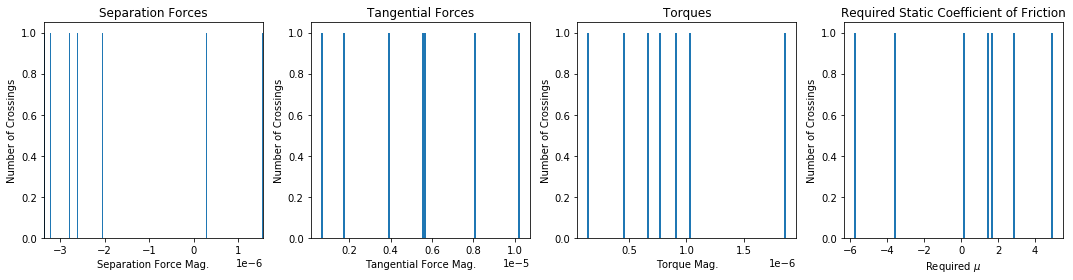

In [35]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [36]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [3 4]
0	0.00011085	0.0952525	0.0952525	1	1
1	8.46823e-05	0.300567	0.300567	1	1
2	3.16949e-05	0.017485	0.017485	1	1
3	2.78209e-05	0.00391672	0.00391672	1	1
4	2.44877e-05	0.00273229	0.00273229	1	1
5	2.15819e-05	0.00204964	0.00204964	1	1
6	1.9242e-05	0.00164809	0.00164809	1	0
7	1.68627e-05	0.0141494	0.0141494	1	1
8	1.48469e-05	0.000405384	0.000405384	1	1
9	1.46879e-05	0.000159011	0.000159011	1	1
10	1.46077e-05	7.78569e-05	7.78569e-05	1	1
11	1.45555e-05	4.51388e-05	4.51388e-05	1	1
12	1.45183e-05	2.7457e-05	2.7457e-05	1	1
13	1.44926e-05	1.69109e-05	1.69109e-05	1	1
14	1.44762e-05	1.08542e-05	1.08542e-05	1	1
15	1.44658e-05	7.24998e-06	7.24998e-06	1	1
16	1.44593e-05	4.69654e-06	4.69654e-06	1	1
17	1.44556e-05	2.98346e-06	2.98346e-06	1	1
18	1.44533e-05	2.00256e-06	2.00256e-06	1	1
19	1.44515e-05	1.59484e-06	1.59484e-06	1	1
20	1.44501e-05	1.4598e-06	1.4598e-06	1	1
21	1.44491e-05	1.43841e-06	1.43841e-06	1	1
22	1.44484e-05	1.36133e-06	1.36133e-06	1	1
23	1.44479e-05	1.53223e-06	1.

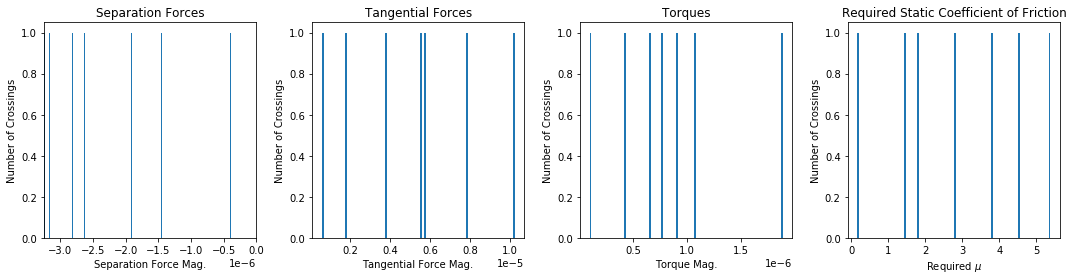

In [37]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [38]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

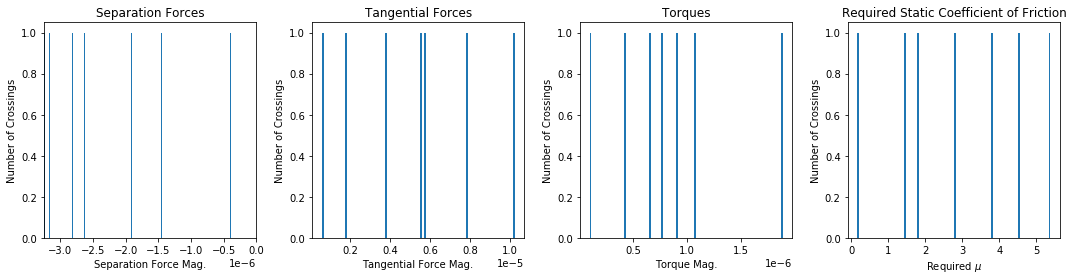

In [39]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

Min Width  0.05
Scale:  100.0
num seg per rod 14
0.2


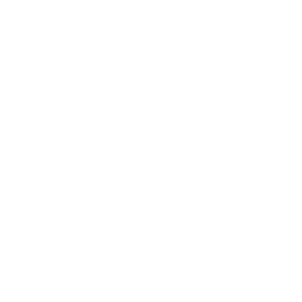

In [42]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_contact_opt', io.RIBBON_NAME + '_contact_opt', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)